# NLP Project Demo

Demonstration of automated clustering of publicly traded US companies based on their business description data.

In [1]:
import os
import string
import pathlib
import pickle

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
import torch

In [6]:
%load_ext autoreload
%autoreload 2

from nvdm.models.nvdm import NVDM

## Helper Functions

In this section, we provide helper function definitions.

### Preprocessing

In [7]:
# Instance of Lemmatizer
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')

def preprocess_text(text):
    """ Process a single line of text. """

    # Strip trailing characters if any (e.g. newline)
    text_new = text.strip()
    
    # Remove puncuation
    text_new = ''.join(ch for ch in text_new if ch not in string.punctuation)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    
    text_new = ' '.join(tokens)

    return text_new

### Model Definitions

We experimented with three types of model:

- K-Means
- Latent Dirichlet Allocation (LDA)
- Neural Variational Document Modelling (NVDM)

For this demo, we only show the "best" model for each type. Please refer to the report and model-specific notebooks for details on hyperparameter selection.

In [125]:
class Model:
    """ Base class for clustering models.
    
    Basically a wrapper for a variety of models.
    """
    def __init__(self):
        pass
    
    def fit(self, X):
        """ Train the model. """
        raise NotImplementedError()
    
    def transform(self, X):
        """ Apply model to new data.
        
        Should output a topic-document matrix,
        where each element is a score indicating how likely the document
        should be assigned to the topic.
        For sklearn LDA, transform() does this by default.
        """
        raise NotImplementedError()
    
    @property
    def topic_vocab_matrix(self):
        """ Each model should be able to return a topic-vocab matrix
        containing a score (e.g. probability) of a word in the vocabulary
        occuring in the k^th topic. """
        pass
    
    # TODO: topic-document matrix
    # TODO: perplexity? Don't think K-Means has a notion of perplexity
    # (because we need probabilities).

    
class KMeansModel(Model):
    """ Wrapper for scikit-learn KMeans. """
    def __init__(self, num_topics):
        self.model = KMeans(
            n_clusters = num_topics,
            init='k-means++',
            max_iter = 300,
            n_init = 10,
            random_state = 0,
            verbose = False)
    
    def fit(self, X):
        self.model.fit(X)

    def transform(self, X):
        """ Returns a topic-document matrix of distances per cluster. """
        return self.model.transform(X)
    
    @property
    def topic_vocab_matrix(self):
        """ Return K-Means clusters.
        
        ndarray of shape (num_topics, n_features)
        """
        return self.model.cluster_centers_


class LDAModel(Model):
    """ Wrapper for scikit-learn LDA. """
    def __init__(self, num_topics):
        self.model = LatentDirichletAllocation(
            n_components=num_topics,
            max_iter=5,
            learning_method='online',
            learning_offset=50.,
            random_state=0)
    
    def fit(self, X):
        self.model.fit(X)
    
    def transform(self, X):
        """ Returns a topic-document matrix of probabilities. """
        return self.model.transform(X)
    
    @property
    def topic_vocab_matrix(self):
        """ Gets the components_ attribute of LDA, normalized
        
        Quoting sklearn docs:
        Variational parameters for topic word distribution.
        Since the complete conditional for topic word distribution is a Dirichlet,
        components_[i, j] can be viewed as pseudocount that represents
        the number of times word j was assigned to topic i.
        It can also be viewed as distribution over the words for each topic after normalization:
        model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
        """
        # return self.model.components_
        return self.model.components_ / self.model.components_.sum(axis=1)[:, np.newaxis]

class NVDMModel(Model):
    """ PyTorch NVDM model.
    
    Loads a pretrained model from disk.
    """
    def __init__(self, model_path, vocab_size, hidden_size=500, num_topics=300):
        self.model = NVDM(vocab_size, hidden_size, num_topics, 1, "cpu")
        self.model.load_state_dict(torch.load(model_path, map_location="cpu"))
        self.model.eval()
        
        decoder = self.model.decoder[0]
        weights = decoder.weight.data.detach().clone().cpu().numpy()
        self.topic_vocab = weights.T
    
    def fit(self, X):
        """ We don't train the model here because it takes too long. """
        pass
    
    def transform(self, X):
        """ Output a topic-document matrix. """
        n_doc, n_vocab = X.shape
        n_topic = self.topic_vocab.shape[0]
        
        # shape (n_doc, n_topic)
        # Score of each document for a topic is the average scores
        # of the document's words in the topic.
        topic_doc = X @ self.topic_vocab.T
        
        # Optionally, normalize by document length.
        topic_doc = topic_doc / X.sum(axis=1, keepdims=True)
        
        return topic_doc
    
    @property
    def topic_vocab_matrix(self):
        """ Returns the learned semantic embeddings of each word. """
        return self.topic_vocab

### Evaluation

We provide functions for evaluation below.
The _topic coherence_ metric is used. TODO perplexity for LDA and NVDM.

In [9]:
# Topic coherence.
def umass_score(tf):
    """ Compute topic coherence using UMass metric.
    
    Ref: http://qpleple.com/topic-coherence-to-evaluate-topic-models/
    
    tf: term-frequency matrix for each document.
        Each i^th row is the BOW representation of the i^th document.
    """
    
    # D(wi): count of documents containing the word wi (i.e. df)
    Dwi = np.array(np.sum(tf > 0, axis=0))[0]

    W_bin = np.zeros_like(tf)
    W_bin[tf > 0] = 1
    
    # D(wi, wj): count of documents containing both words wi and wj
    Dwi_wj = W_bin.T @ W_bin

    score_umass = np.log((Dwi_wj + 1)/ Dwi)
    
    return score_umass

def topic_coherence(topic_vocab, n_top_words, pair_score):
    """ Compute the topic coherence of each topic,
    given a learned topic-vocabulary matrix, the number of top words to use
    and a matrix of pairwise scores (e.g. umass_score output)
    
    topic_vocab: dimensions (number of topics, vocabulary size).
    model.components_ for LDA, and the "semantic embedding" matrix in the decoder for NVDM.
    
    pair_score: matrix of scores (e.g. UMass)
    """
    coherences = []
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

def plot_top_words(topic_vocab, feature_names, n_top_words, title):
    """ Given a topic-vocabulary matrix containing scores
    (e.g. probabilities, higher the better),
    plot the top words as a frequency bar-graph for each topic.
    
    e.g. set topic_vocab=model._components for LDA.
    """
    K = len(topic_vocab)
    n_x = 5
    n_y = int(np.ceil(K / n_x))
    fig, axes = plt.subplots(n_y, n_x, figsize=(2.5 * n_x, 4 * n_y), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    # plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    fig.tight_layout()
    plt.show()

### Data-Loading

Functions for loading all business description datasets (S&P500 and bds1).

In [10]:
def load_sp500(path, preprocess=False):
    """ Load S&P500 data from the per-company text files in the supplied directory path.
    
    Within the directory, each file is named "<ticker>_<sector>.txt".
    Each contains the business description (BD) of the company.
    
    If preprocess is True, the preprocess the business descriptions at the same time.
    """
    filenames = os.listdir(path)

    tickers = []
    sectors = []
    bds = []
    for fn in filenames:
        prefix = fn.split('.txt')[0]
        ticker, sector = prefix.split('_')
        filepath = os.path.join(path, fn)
        with open(filepath, 'r', encoding="utf8") as f:
            bd = f.read().strip()
        
        if preprocess:
            bd = preprocess_text(bd)

        tickers.append(ticker)
        sectors.append(sector)
        bds.append(bd)
    
    return tickers, sectors, bds


def load_bds1(path, preprocess=False, exclude_tickers=None):
    """ Load data from the business data, given the file path (e.g. "data/bds_1.txt").
    
    In the file, each company has two consecutive lines.
    The first line is <company ticker>:<CIK> (we only care about the ticker)
    and the second line is the company business description.
    
    exclude_tickers is a list of tickers that we want to ignore in bds_1.txt.
    For example, we can use this to exclude any S&P500 companies to avoid
    overlapping of datasets.
    """
    
    with open(path, "r", encoding="utf8") as f:
        lines = f.readlines()

    company_ids_all = [ln.strip() for ln in lines[0::2]]
    company_descriptions_all = [ln.strip() for ln in lines[1::2]]
    company_tickers = [x.split(':')[0] for x in company_ids_all]

    exclusion_set = set(exclude_tickers) if exclude_tickers is not None else set()

    tickers = []
    bds = []
    
    # Some business descriptions are too short (or even empty),
    # so we only keep those with a length (number of characters) deemed reasonable.
    bd_valid_length = 3000
    for ticker, bd in zip(company_tickers, company_descriptions_all):
        if ticker not in exclusion_set and len(bd) >= bd_valid_length:
            tickers.append(ticker)
            
            if preprocess:
                bd = preprocess_text(bd)
            bds.append(bd)
    
    return tickers, bds

## Begin Demo

In [11]:
%%time
# Load and preprocess S&P500 and BDS1 data.
# We use BDS1 as the training set and S&P500 as the validation set.
sp500_tickers, sp500_sectors, sp500_bds = load_sp500("./SP500", preprocess=True)
bds1_tickers, bds1_bds = load_bds1("./nvdm/data/bds_1.txt", preprocess=True, exclude_tickers=sp500_tickers)

CPU times: user 1min 2s, sys: 395 ms, total: 1min 2s
Wall time: 1min 3s


In [12]:
# FEATURE EXTRACTION
# Use this to convert text to a Bag-of-Words (term-frequency) representation.
# We "train" this vectorizer on S&P500 only, assuming the BDS1 validation set is "unseen".
# When evaluating, if a word in a business description from BDS1 doesn't exist in S&P500 data,
# then it will be ignored.

# Only keep top n most frequent words (adjust futher if required)
# These parameters (except stopwords, since they are already removed)
# were used in LDA notebooks. Adjust if needed.
n_features = 4000
tf_vectorizer = CountVectorizer(max_features=n_features, max_df=0.95, min_df=2)
tf_vectorizer.fit(sp500_bds)

CountVectorizer(max_df=0.95, max_features=4000, min_df=2)

In [80]:
X_sp500 = tf_vectorizer.transform(sp500_bds).toarray()

### K-Means

In [44]:
kmeans = KMeansModel(5)
kmeans.fit(X_sp500)

In [61]:
preds = kmeans.transform(X_sp500)

In [66]:
# Group the companies by the most likely topic assignment.
# Argmin, because K-Means.transform() outputs distances of companies to each cluster,
# so we want the topic with the smallest distance.
# (in contrast with LDA, which outputs topic probabilities, so we want argmax)
topic_per_company = preds.argmin(axis=1)
groups = dict((i, []) for i in range(len(topic_per_company)))
for company_idx in range(len(topic_per_company)):
    topic = topic_per_company[company_idx]
    groups[topic].append(company_idx)

In [68]:
# Show the tickers for an example group
# Compare them to their actual industry sector
[(sp500_tickers[i], sp500_sectors[i]) for i in groups[0]]

[('COF', 'Financials'),
 ('MTB', 'Financials'),
 ('BRK.B', 'Financials'),
 ('SIVB', 'Financials'),
 ('PFG', 'Financials'),
 ('AIG', 'Financials'),
 ('AMP', 'Financials'),
 ('CFG', 'Financials'),
 ('CINF', 'Financials'),
 ('STT', 'Financials'),
 ('USB', 'Financials'),
 ('RE', 'Financials'),
 ('CMA', 'Financials'),
 ('NTRS', 'Financials'),
 ('BEN', 'Financials'),
 ('PRU', 'Financials'),
 ('SCHW', 'Financials'),
 ('AIZ', 'Financials'),
 ('WU', 'Information Technology'),
 ('TRV', 'Financials'),
 ('KEY', 'Financials'),
 ('RF', 'Financials'),
 ('HBAN', 'Financials'),
 ('SYF', 'Financials'),
 ('RJF', 'Financials'),
 ('CB', 'Financials'),
 ('ALL', 'Financials'),
 ('WELL', 'Real Estate'),
 ('GS', 'Financials'),
 ('ZION', 'Financials'),
 ('PNC', 'Financials'),
 ('UNM', 'Financials'),
 ('MS', 'Financials'),
 ('CBOE', 'Financials'),
 ('AXP', 'Financials'),
 ('O', 'Real Estate'),
 ('BLK', 'Financials'),
 ('C', 'Financials'),
 ('LNC', 'Financials'),
 ('MET', 'Financials'),
 ('DFS', 'Financials'),
 (

In [47]:
kmeans_topic_coherence = topic_coherence(kmeans.topic_vocab_matrix, 10, umass_score(X_sp500))
print(np.median(kmeans_topic_coherence))

-15.161944975077024
 

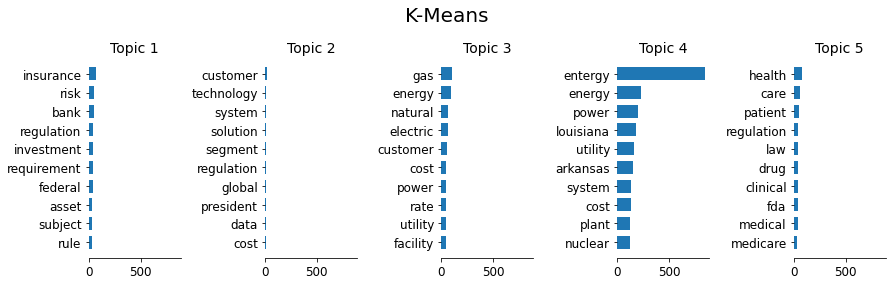

In [48]:
plot_top_words(kmeans.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "K-Means")

### LDA

In [98]:
lda = LDAModel(15)
lda.fit(X_sp500)

In [99]:
preds = lda.transform(X_sp500)

In [100]:
# Group the companies by the most likely topic assignment.
# argmax because we want the topic with highest probability.
topic_per_company = preds.argmax(axis=1)
groups = dict((i, []) for i in range(len(topic_per_company)))
for company_idx in range(len(topic_per_company)):
    topic = topic_per_company[company_idx]
    groups[topic].append(company_idx)

(503,)


In [56]:
# Show the tickers for an example group
# Compare them to their actual industry sector
[(sp500_tickers[i], sp500_sectors[i]) for i in groups[12]]

[('PFG', 'Financials'),
 ('AIG', 'Financials'),
 ('CINF', 'Financials'),
 ('RE', 'Financials'),
 ('PRU', 'Financials'),
 ('AJG', 'Financials'),
 ('AIZ', 'Financials'),
 ('TRV', 'Financials'),
 ('CB', 'Financials'),
 ('ALL', 'Financials'),
 ('AON', 'Financials'),
 ('MMC', 'Financials'),
 ('UNM', 'Financials'),
 ('AFL', 'Financials'),
 ('LNC', 'Financials'),
 ('MET', 'Financials'),
 ('PGR', 'Financials'),
 ('GL', 'Financials'),
 ('WRB', 'Financials'),
 ('HIG', 'Financials')]

In [81]:
lda_topic_coherence = topic_coherence(lda.topic_vocab_matrix, 10, umass_score(X_sp500))
print(np.mean(lda_topic_coherence))

45.83544402053764


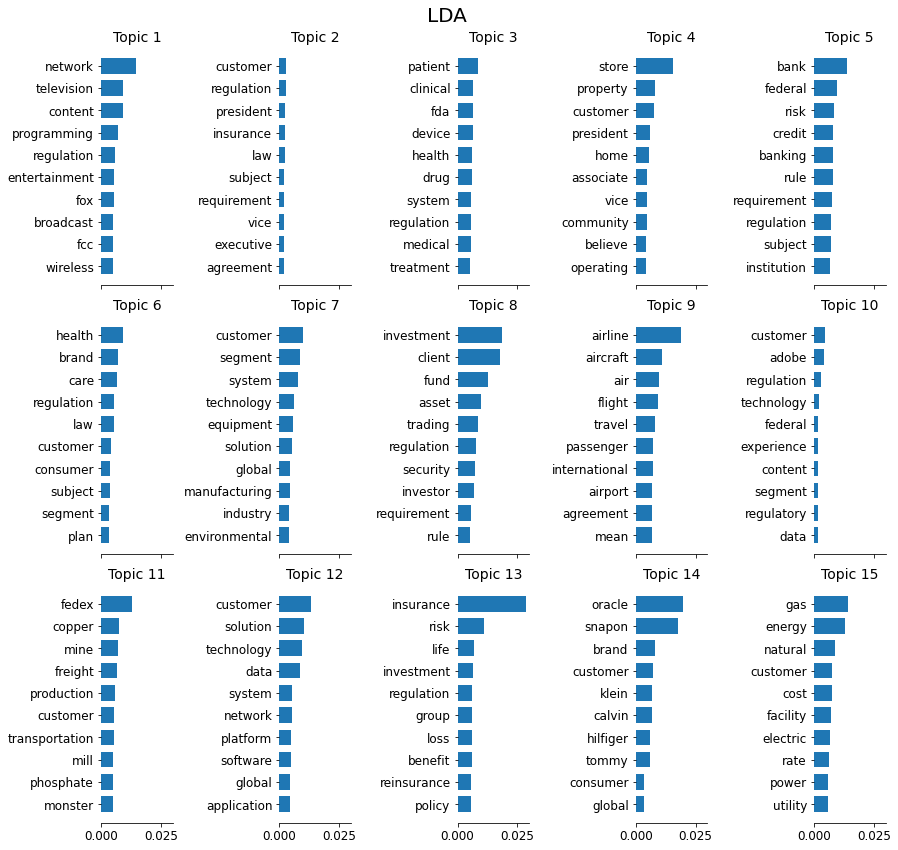

In [186]:
plot_top_words(lda.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "LDA")

### NVDM

In [126]:
nvdm = NVDMModel("./nvdm/modelsaves/nvdm_k300_1000epochs.pt", len(tf_vectorizer.get_feature_names()))

In [127]:
preds = nvdm.transform(X_sp500)

In [132]:
# Group the companies by the most likely topic assignment.
# Argmin, because K-Means.transform() outputs distances of companies to each cluster,
# so we want the topic with the smallest distance.
# (in contrast with LDA, which outputs topic probabilities, so we want argmax)
topic_per_company = preds.argmax(axis=1)
groups = dict((i, []) for i in range(len(topic_per_company)))
for company_idx in range(len(topic_per_company)):
    topic = topic_per_company[company_idx]
    groups[topic].append(company_idx)

In [143]:
# Show the tickers for an example group
# Compare them to their actual industry sector
print([key for key, val in groups.items() if len(val) > 0])
[(sp500_tickers[i], sp500_sectors[i]) for i in groups[50]]

[8, 18, 21, 26, 50, 61, 70, 81, 90, 94, 136, 179, 190, 210, 271, 286]


[('AEE', 'Utilities'),
 ('AAL', 'Industrials'),
 ('NOC', 'Industrials'),
 ('NSC', 'Industrials'),
 ('SO', 'Utilities'),
 ('SRE', 'Utilities'),
 ('ES', 'Utilities'),
 ('DLTR', 'Consumer Discretionary'),
 ('LRCX', 'Information Technology'),
 ('EXC', 'Utilities'),
 ('MOS', 'Materials'),
 ('PKG', 'Materials'),
 ('ED', 'Utilities'),
 ('XEL', 'Utilities'),
 ('FE', 'Utilities'),
 ('CMS', 'Utilities'),
 ('PPL', 'Utilities'),
 ('WEC', 'Utilities'),
 ('LHX', 'Industrials'),
 ('EVRG', 'Utilities'),
 ('ATO', 'Utilities'),
 ('GPC', 'Consumer Discretionary'),
 ('MCHP', 'Information Technology'),
 ('AZO', 'Consumer Discretionary'),
 ('PEG', 'Utilities'),
 ('CSX', 'Industrials'),
 ('NUE', 'Materials'),
 ('NRG', 'Utilities'),
 ('SWKS', 'Information Technology'),
 ('CNP', 'Utilities'),
 ('NI', 'Utilities'),
 ('D', 'Utilities'),
 ('LNT', 'Utilities'),
 ('ETR', 'Utilities'),
 ('NEE', 'Utilities'),
 ('HWM', 'Industrials'),
 ('AES', 'Utilities'),
 ('MPWR', 'Information Technology'),
 ('DUK', 'Utilities'),
 

In [77]:
nvdm_topic_coherence = topic_coherence(nvdm.topic_vocab_matrix, 10, umass_score(X_sp500))
print(np.mean(nvdm_topic_coherence))

-68.81099552908266


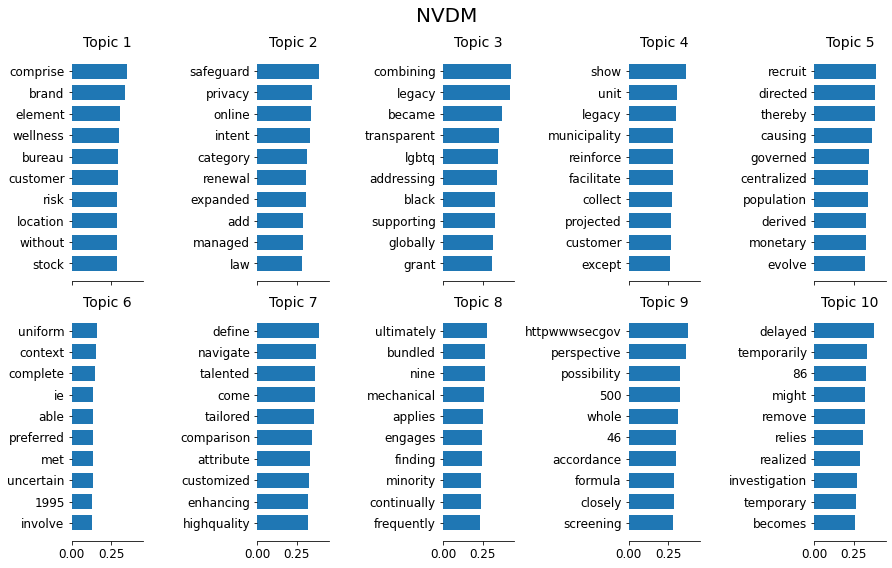

In [78]:
# Since there are too many topics (300),
# we only sample a few.

idx = np.array(nvdm_topic_coherence).argsort()[:-10 - 1:-1]
#idx = np.random.choice(nvdm.topic_vocab_matrix.shape[0], size=10)
plot_top_words(nvdm.topic_vocab_matrix[idx], tf_vectorizer.get_feature_names(), 10, "NVDM")